In [79]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (128, 128)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/silica4/', 'test_train', spheric_poses=True,
#            img_wh=img_wh)

In [4]:
dataset = dataset_dict['beldner'] \
          ('/home/ktiwary/cv-graphics/datasets/volumetric/single_box_pyredner/scene_1/', 'val',
           img_wh=img_wh)

!ls ./ckpts/single_cube_new_znearfar_bounds/epoch=99.ckpt

'./ckpts/single_cube_new_znearfar_bounds/epoch=99.ckpt'


In [9]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = './ckpts/single_cube_new_znearfar_bounds/epoch=99.ckpt'
# ckpt_path = 'ckpts/exp2/epoch=05.ckpt'

# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [6]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [11]:
sample = dataset[1]
rays = sample['cam_ray_bundle'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

0.9428904056549072


PSNR 4.664218902587891


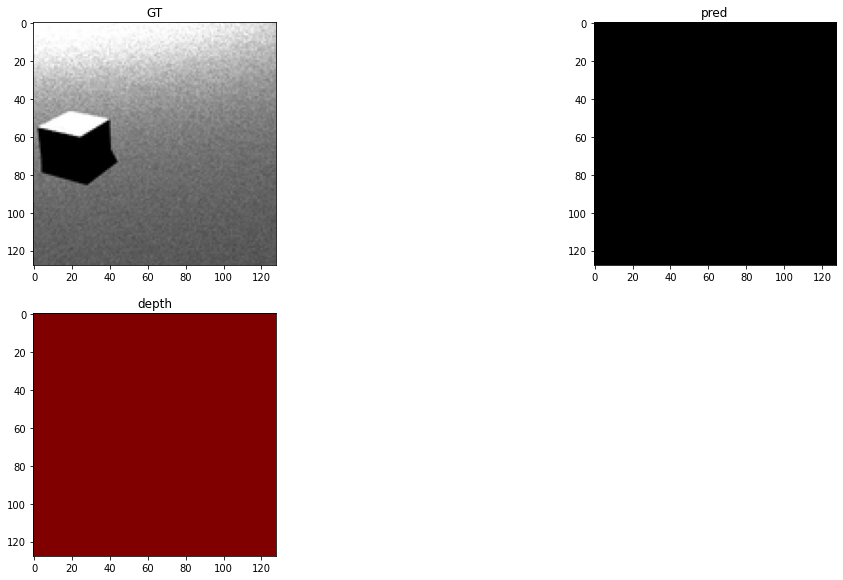

In [12]:
img_gt = sample['rgb'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

In [44]:
sample.keys()

dict_keys(['img_id', 'rgb', 'shadow_maps', 'cam_ray_bundle', 'light_ray_bundle', 'hw'])

In [ ]:
from PIL import Image
import torch
from torchvision import transforms as T


f = '/u/ktiwary/cv-graphics/datasets/volumetric/results_500/r_450.png'
img = Image.open(f)
img = img.resize((400,400), Image.LANCZOS).convert('L')
img = np.array(img)
img = T.ToTensor()(img)
# img = torch.tensor(img).unsqueeze(2)
print(img.shape)
img = torch.cat([img, img, img], dim=0)
print(img.shape)

plt.imshow(img.permute(1,2,0).numpy())#, img.shape

torch.Size([1, 400, 400])
torch.Size([3, 400, 400])


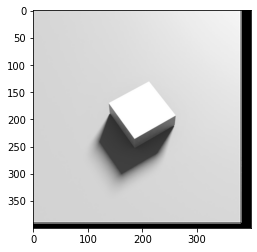

In [80]:
from PIL import Image
import torch
from torchvision import transforms as T


f = '/u/ktiwary/cv-graphics/datasets/volumetric/results_500/r_450.png'
img = Image.open(f)
img = img.resize((400,400), Image.LANCZOS).convert('L')
img = np.array(img)
img = T.ToTensor()(img)
# img = torch.tensor(img).unsqueeze(2)
print(img.shape)
img = torch.cat([img, img, img], dim=0)
print(img.shape)

plt.imshow(img.permute(1,2,0).numpy())#, img.shape

In [118]:
from PIL import Image
import torch
from torchvision import transforms as T


f = '/u/ktiwary/cv-graphics/datasets/volumetric/results_500/sm_r_450.png'
img = Image.open(f)
img = img.resize((400,400), Image.LANCZOS)#.convert('L')
img
# print(np.array(img).shape)
# img = np.array(img)
img = T.ToTensor()(img)
# # img = torch.tensor(img).unsqueeze(2)
# print(img.shape)
# img = torch.cat([img, img, img], dim=0)
print(img.shape)

# plt.imshow(img.permute(1,2,0).numpy())#, img.shape

torch.Size([3, 400, 400])


In [116]:
img = np.array(img)

np.where(img==1)[1][1], img[188,141]

(141, array([1, 1, 1], dtype=uint8))

In [131]:
import json

f = "../datasets/volumetric/results_500_v2/transforms.json"
with open(f) as out:
    data = json.load(out)
    
data['light_camera_transform_matrix'], data['light_camera_angle_x']

([[0.8944, -0.4472, 0.0, 200.0],
  [0.4472, 0.8944, 0.0, -400.0],
  [0.0, 0.0, 1.0, 500.0],
  [0.0, 0.0, 0.0, 1.0]],
 0.3490658402442932)

In [124]:
# !cat ../datasets/volumetric/results_500_v2/transforms.json

{
    "camera_angle_x": 0.4029563069343567,
    "light_camera_angle_x": 0.3490658402442932,
    "light_camera_transform_matrix": [
        [
            0.8944,
            -0.4472,
            0.0,
            200.0
        ],
        [
            0.4472,
            0.8944,
            0.0,
            -400.0
        ],
        [
            0.0,
            0.0,
            1.0,
            500.0
        ],
        [
            0.0,
            0.0,
            0.0,
            1.0
        ]
    ],
    "frames": [
        {
            "file_path": "/Users/ktiwary/mit/datasets/blend_files/results_500_v2//r_0",
            "rotation": 0.012566370614359171,
            "transform_matrix": [
                [
                    0.37299811840057373,
                    0.9050593972206116,
                    -0.20430323481559753,
                    -23.196290969848633
                ],
                [
                    -0.9278321862220764,
                    0.3638432621955871

                    0.8234654068946838,
                    93.49507141113281
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ]
        },
        {
            "file_path": "/Users/ktiwary/mit/datasets/blend_files/results_500_v2//r_333",
            "rotation": 0.012566370614359171,
            "transform_matrix": [
                [
                    -0.48650074005126953,
                    0.8441806435585022,
                    -0.22511322796344757,
                    -25.55902862548828
                ],
                [
                    -0.8736802935600281,
                    -0.4700741767883301,
                    0.12535220384597778,
                    14.232307434082031
                ],
                [
                    0.0,
                    0.2576608657836914,
                    0.966235339641571,
                    109.7049560546875
    